In [762]:
#ideas for importing data:
#1. get data in batches: export to a list, export list to a csv, import csv for each new run - do data preprocessing
#2. get data in batches, process each batch, export to a csv, import csv with specified datatypes
#3. how big is a "big" dataset? whats the general limit for what i can export to work with on my computer?
#4. multithreading vs. multiprocessing?
#5. export data to a database? SQLalchemy
#6. work directly in colab, then download and export to github?

## Import dataset, reduce memory

In [ ]:
#options:
#1. download locally, wait for however long it takes, large = when it stops fitting in ram
#mem = temp working space, fast to access but can't store much, might be erased; disk = long term storage
#goal = get something done quickly
#embarrassingly parallel problems: processes don't need to talk to each other 

#2. BQ: data stays in google servers, might have to pay eventually, if you need to do a lot of processing / really large datasets
#take the processed results 
#use api to query from BQ

#3. spark cluster on AWS

#keep raw data - quickly recover

#python stores each num as an obj; each obj has overhead involved (methods, value, ref count)
#numpy stores all of these values as one obj

In [747]:
import pandas as pd
import numpy as np
import requests
#python client for Socrata open data API
from sodapy import Socrata
import os
import seaborn as sns
from matplotlib import pyplot as plt
import sys
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pygsheets

os.getcwd()
pd.options.display.max_columns=50

In [19]:
#define parameters for endpoint, dataset, and app token
data_url = 'data.cityofnewyork.us'
dataset = 'erm2-nwe9'
app_token = 'dM7DDeidbAmgtydtJVV1epbiU'

#sets up the connection, need application token to override throttling limits
#username and password only required for creating or modifying data
client = Socrata(data_url, app_token)
client.timeout = 6000

#count number of records in desired dataset
record_count = client.get(dataset, select='count(*)', where="created_date >='2019-01-01'")
record_count

[{'count': '3049868'}]

In [20]:
def get_data(chunk_size=100000, total_rows=300000):
    start = 0
    results=[]

    #paginate through dataset in sets of 10000 to get all records since 2019
    while True:
        print(start)
        results.extend(client.get(dataset,where="created_date >= '2019-01-01'", 
                                  limit=chunk_size, offset=start))
        start += chunk_size
        if start > total_rows:
            break
            
#orig_results - all dtypes are objects
#orig_results = pd.DataFrame(results)
#orig_results.to_csv('/Users/christinejiang/Documents/Python/data/311_data.csv', index=False)

0
100000
200000


In [581]:
def old_memory_reduction(dataframe):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
        this is an older method; it does not consider whether there is a low number of unique values in a column 
        in order to warrant use of categorical data type instead of object. 
        basically does manual downcasting; this is uncessary if we use pd.to_numeric(downcast=type)
        also does inplace operation, which we don't want.
    """
    start_mem = dataframe.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    #print(col, col_type, 'int8')
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    #print(col, col_type, 'int16')
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    #print(col, col_type, 'int32')
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    #print(col, col_type, 'int64')
                    dataframe[col] = dataframe[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    #print(col, col_type, 'float16')
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    #print(col, col_type, 'float32')
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    #print(col, col_type, 'float64')
                    dataframe[col] = dataframe[col].astype(np.float64)
        else:
            #print(col, col_type, 'category')
            dataframe[col] = dataframe[col].astype('category')
            
    end_mem = dataframe.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return dataframe

def get_mem_usage(df):
    dtypes = df.dtypes.astype(str).unique()
    total_mem = df.memory_usage().sum()/1024**2
    for dtype in dtypes:
        selected_dtype = df.select_dtypes(include=dtype)
        mean_usage_b = selected_dtype.memory_usage().mean()
        mean_usage_mb = mean_usage_b / 1024**2
        print('avg memory usage for {} columns: {:03.2f} MB'.format(dtype, mean_usage_mb))
    print(f'total memory usage: {total_mem:.2f}')
    
def new_memory_reduction(df):
    """improved version of memory reduction function. uses pd.to_numeric to downcast types;
    also considers whether there are few enough unique values to warrant use of category vs. object."""
    orig_size = df.memory_usage().sum()/1024**2
    dtypes = df.dtypes.astype(str).unique()
    converted_float = pd.DataFrame()
    converted_int = pd.DataFrame()
    converted_obj = pd.DataFrame()
    for dtype in dtypes:
        if 'float' in dtype:
            selected_float = df.select_dtypes(include='float')
            converted_float = selected_float.apply(pd.to_numeric, downcast='float')
            float_size = selected_float.memory_usage().sum()/1024**2
            converted_float_size = converted_float.memory_usage().sum()/1024**2
            print(f'floats: {float_size:.2f} reduced to {converted_float_size:.2f} MB')
        if 'int' in dtype:
            selected_int = df.select_dtypes(include='integer')
            converted_int = selected_int.apply(pd.to_numeric, downcast='integer')
            int_size = selected_int.memory_usage().sum()/1024**2
            converted_int_size = converted_int.memory_usage().sum()/1024**2
            print(f'ints: {int_size:.2f} reduced to {converted_int_size:.2f} MB')
        if 'object' in dtype:
            selected_object = df.select_dtypes(include='object')
            obj_size = selected_object.memory_usage().sum()/1024**2
            for col in selected_object.columns:
                count = len(selected_object[col])
                unique = len(selected_object[col].astype(str).unique())
                if unique < count/2:
                    converted_obj[col] = selected_object[col].astype(str).astype('category')
                else:
                    converted_obj[col] = selected_object[col].astype(str)
            converted_obj_size = converted_obj.memory_usage().sum()/1024**2
            print(f'object: {obj_size:.2f} reduced to {converted_obj_size:.2f} MB')

    float_int = converted_float.join(converted_int)
    reduced_df = float_int.join(converted_obj)
    reduced_df = reduced_df[df.columns]
    reduced_size = reduced_df.memory_usage().sum()/1024**2
    print(f'final df: {orig_size:.2f} reduced to {reduced_size:.2f} MB, {(orig_size-reduced_size)/orig_size*100:.1f}% reduction')
    return reduced_df

def preprocess_df(df):
    cleandf = df.drop(['intersection_street_1',
               'intersection_street_2',
               'taxi_company_borough',
               'taxi_pick_up_location',
               'bridge_highway_name',
               'bridge_highway_direction',
               'road_ramp',
               'bridge_highway_segment',
               'landmark',
               'vehicle_type'], axis=1, inplace=False)

    for col in df.columns:
        if 'date' in col:
            cleandf[col] = pd.to_datetime(newdf[col])
            
    cleandf['created_year'] = [x.year for x in cleandf['created_date']]
    cleandf['created_month'] = [x.month for x in cleandf['created_date']]
    cleandf['created_day'] = [x.day for x in cleandf['created_date']]
    cleandf['created_hour'] = [x.hour for x in cleandf['created_date']]
    cleandf['closed_hour'] = [x.hour for x in cleandf['closed_date']]
    cleandf['time_to_close'] = cleandf['closed_date'] - cleandf['created_date']
    return cleandf

In [568]:
#olddf - most dtypes are objects, some are ints and some are floats
#BUT olddf datatypes get changed inplace after running reduce_mem_usage! becomes mostly categorical
#olddf = pd.read_csv('/Users/christinejiang/Documents/Python/data/311_data.csv')

#newdf - most dtypes are categorical, some ints and floats
newdf = new_memory_reduction(olddf)

cleaneddf = preprocess_df(newdf)

ints: 2.29 reduced to 1.14 MB
object: 80.11 reduced to 48.73 MB
floats: 11.44 reduced to 5.72 MB
final df: 93.84 reduced to 55.59 MB, 40.8% reduction


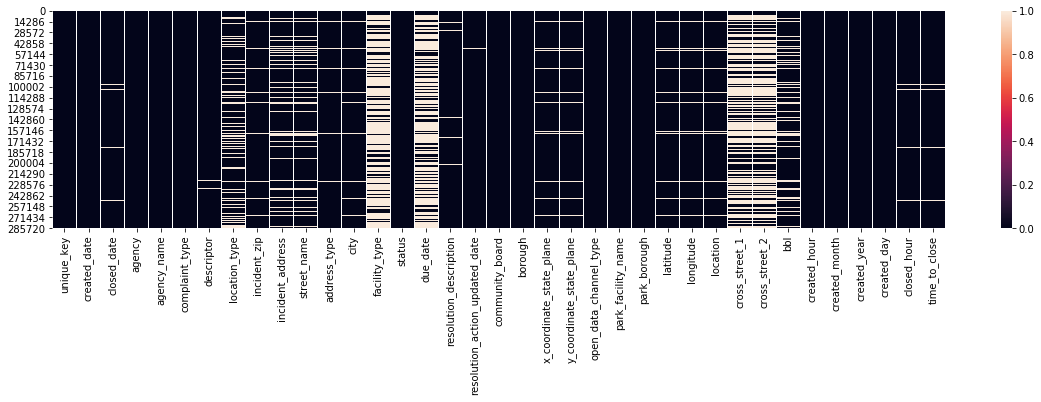

In [699]:
sns.heatmap(cleaned_df.isnull())

## Text Cleaning

In [871]:
cleaned_df.head(2)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,address_type,city,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,cross_street_1,cross_street_2,bbl,created_hour,created_month,created_year,created_day,closed_hour,time_to_close
0,41309122,2019-01-01,2019-01-10,DOHMH,Department of Health and Mental Hygiene,Rodent,Mouse Sighting,3+ Family Apt. Building,11373,90-34 52 AVENUE,52 AVENUE,LATLONG,ELMHURST,NaN,Closed,2019-01-31 01:28:20,The Department of Health and Mental Hygiene wi...,2019-01-10 00:00:00,Unspecified QUEENS,QUEENS,1019585.0,208494.0,MOBILE,Unspecified,QUEENS,40.738873,-73.872490,"{'latitude': '40.7388739110531', 'longitude': ...",NaN,NaN,NaN,0,1,2019,1,0.0,9 days
1,41310910,2019-01-01,2019-01-01,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10459,899 EAST 169 STREET,EAST 169 STREET,LATLONG,BRONX,NaN,Closed,2019-01-31 00:57:25,The Department of Health and Mental Hygiene wi...,2019-01-01 00:59:56,Unspecified BRONX,BRONX,1013183.0,241128.0,MOBILE,Unspecified,BRONX,40.828468,-73.895454,"{'latitude': '40.82846874659817', 'longitude':...",NaN,NaN,NaN,0,1,2019,1,0.0,0 days


In [1000]:
#agency name: look at top 10-20
#complaint type: needs to be grouped
#descriptor: needs to be cleaned
#location type: needs to be cleaned
#city: needs to be cleaned
#resolution description: NLP extraction?
#community board: extract last charaters, same as borough
#parks: visualize parks?

#write function that will export all unique values and their counts to google sheets
#one sheet per column

def export_col_values(workbook, columns):
    for col in columns:
        value_counts = cleaned_df[col].value_counts()
        counts_df = pd.DataFrame(value_counts).reset_index()
        try:
            worksheet = workbook.worksheet_by_title(col)
        except WorksheetNotFound:
            workbook.add_worksheet(col)
            worksheet = workbook.worksheet_by_title(col)
        worksheet.set_dataframe(counts_df, start='A1')
    print(f'{len(columns)} sets of column values exported.')
        
def get_valid_names(workbook, columns, start='D1'):
    valid_names = {}
    for col in columns:
        worksheet = workbook.worksheet_by_title(col)
        valid_matrix = worksheet.get_values(start='D1', end='D100')
        valid_names[col] = [v[0] for v in valid_matrix]
    return valid_names

#function will fuzzy match with correct valid list
def fuzzy_match(value):
    match = process.extract(query=value, choices=valid_names[col], limit=1)
    if match[0][1] < 90:
        return 'Other'
    else:
        return match[0][0]


In [ ]:
client = pygsheets.authorize(service_account_file='/Users/christinejiang/Documents/Python/data/client_secret.json')
workbook = client.open('311_data_cleaning')
columns = ['agency_name','complaint_type','descriptor','location_type','city']

export_col_values(workbook, columns)
valid_names = get_valid_names(workbook, columns, start='D1')

In [ ]:
for col in columns:
    cleaned_df['cleaned_'+col] = cleaned_df[col].apply(fuzzy_match)

In [1002]:
cleaned_df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,address_type,city,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,cross_street_1,cross_street_2,bbl,created_hour,created_month,created_year,created_day,closed_hour,time_to_close,cleaned_agency,cleaned_agency_score,cleaned_agency_name,cleaned_complaint_type,cleaned_descriptor,cleaned_location_type,cleaned_city
0,41309122,2019-01-01,2019-01-10,DOHMH,Department of Health and Mental Hygiene,Rodent,Mouse Sighting,3+ Family Apt. Building,11373,90-34 52 AVENUE,52 AVENUE,LATLONG,ELMHURST,NaN,Closed,2019-01-31 01:28:20,The Department of Health and Mental Hygiene wi...,2019-01-10 00:00:00,Unspecified QUEENS,QUEENS,1019585.0,208494.0,MOBILE,Unspecified,QUEENS,40.738873,-73.872490,"{'latitude': '40.7388739110531', 'longitude': ...",NaN,NaN,NaN,0,1,2019,1,0.0,9 days,Department of Health and Mental Hygiene,100,Department of Health and Mental Hygiene,Rodent,Other,Other,Elmhurst
1,41310910,2019-01-01,2019-01-01,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10459,899 EAST 169 STREET,EAST 169 STREET,LATLONG,BRONX,NaN,Closed,2019-01-31 00:57:25,The Department of Health and Mental Hygiene wi...,2019-01-01 00:59:56,Unspecified BRONX,BRONX,1013183.0,241128.0,MOBILE,Unspecified,BRONX,40.828468,-73.895454,"{'latitude': '40.82846874659817', 'longitude':...",NaN,NaN,NaN,0,1,2019,1,0.0,0 days,Department of Health and Mental Hygiene,100,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other,Bronx
2,41314898,2019-01-01,2019-01-01,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Other (Explain Below),11208,790 ELDERT LANE,ELDERT LANE,ADDRESS,BROOKLYN,NaN,Closed,2019-01-31 15:56:12,The Department of Health and Mental Hygiene wi...,2019-01-01 16:11:05,05 BROOKLYN,BROOKLYN,1022225.0,183607.0,PHONE,Unspecified,BROOKLYN,40.670555,-73.863106,"{'latitude': '40.67055409879978', 'longitude':...",DUMONT AVENUE,LINDEN BOULEVARD,3.042719e+09,0,1,2019,1,0.0,0 days,Department of Health and Mental Hygiene,100,Department of Health and Mental Hygiene,Rodent,Other,Other,Brooklyn
3,41315045,2019-01-01,2019-01-03,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Commercial Building,11412,NaN,NaN,INTERSECTION,Saint Albans,NaN,Closed,2019-01-31 15:03:23,The Department of Health and Mental Hygiene wi...,2019-01-03 00:00:00,12 QUEENS,QUEENS,1046613.0,196294.0,PHONE,Unspecified,QUEENS,40.705238,-73.775070,"{'latitude': '40.70523868495376', 'longitude':...",NaN,NaN,NaN,0,1,2019,1,0.0,2 days,Department of Health and Mental Hygiene,100,Department of Health and Mental Hygiene,Rodent,Other,Other,Other
4,41315071,2019-01-01,2019-01-02,DOHMH,Department of Health and Mental Hygiene,Rodent,Mouse Sighting,3+ Family Apt. Building,10468,2825 CLAFLIN AVENUE,CLAFLIN AVENUE,LATLONG,BRONX,NaN,Closed,2019-01-31 12:23:06,The Department of Health and Mental Hygiene wi...,2019-01-02 00:00:00,Unspecified BRONX,BRONX,1011869.0,257276.0,MOBILE,Unspecified,BRONX,40.872795,-73.900131,"{'latitude': '40.872794400702894', 'longitude'...",NaN,NaN,NaN,0,1,2019,1,0.0,1 days,Department of Health and Mental Hygiene,100,Department of Health and Mental Hygiene,Rodent,Other,Other,Bronx


In [1011]:
cleaned_df.groupby(['location_type', 'cleaned_location_type'])['unique_key'].count().to_frame().sort_values('unique_key', ascending=False)


,,unique_key
location_type,cleaned_location_type,
RESIDENTIAL BUILDING,Building (Non-Residential),100528
Street/Sidewalk,Sidewalk / Street,41564
Sidewalk,Sidewalk / Street,35323
Residential Building/House,Residential,21243
Street,Sidewalk / Street,18317
Property Address,Property Address,2877
Store/Commercial,Store/Commercial,2723
Club/Bar/Restaurant,Club/Bar/Restaurant/Deli,1602
Senior Address,Senior Address,1409
